In [1]:
from IPython.display import IFrame
IFrame(src="https://www.youtube.com/embed/PY6PWondOeQ", width=1920/4, height=1080/4)
# <iframe width="560" height="315" src="https://www.youtube.com/embed/PY6PWondOeQ" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [25]:
from _easy_qiskit_init import *
plt.style.use('dark_background')

In [26]:
# map fermionic operators to spin operators
# qubit Hamiltonian behaves like molecular Hamiltonian

In [27]:
# N-site spinless tight-binding model
# defect in chain
N_sites = 5
hopping_terms = []

for ii in range(N_sites - 1):
    hopping_terms.append(sum(FermionicOp(label, register_length=N_sites)
                            for label in ['+_%i -_%i' % (ii, ii+1),
                                          '+_%i -_%i' % (ii+1, ii)]))
    # creation and annihilation operators

In [28]:
hopping_terms

[FermionicOp([('+_0 -_1', (1+0j)), ('+_1 -_0', (1+0j))], register_length=5, display_format='sparse'),
 FermionicOp([('+_1 -_2', (1+0j)), ('+_2 -_1', (1+0j))], register_length=5, display_format='sparse'),
 FermionicOp([('+_2 -_3', (1+0j)), ('+_3 -_2', (1+0j))], register_length=5, display_format='sparse'),
 FermionicOp([('+_3 -_4', (1+0j)), ('+_4 -_3', (1+0j))], register_length=5, display_format='sparse')]

In [29]:
mapper = JordanWignerMapper()
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)
# Fermionic to Pauli Hamiltonian via JW transformation

In [30]:
tau = Parameter('$\\tau$') # non-defect sites
tau_def = Parameter('$\\tau_d$') # defect sites

defect_sites = [2]
ham_jw = 0 # jw = Jordan Wigner
for hidx, hopping_term in enumerate(hopping_terms):
    if hidx in defect_sites:
        ham_jw += tau_def*converter.convert(hopping_term)
    else:
        ham_jw += tau*converter.convert(hopping_term)

In [31]:
ham_jw
# qubit 0 least significant digit now

SummedOp([PauliSumOp(SparsePauliOp(['IIIYY', 'IIIXX'],
              coeffs=[0.5+0.j, 0.5+0.j]), coeff=1.0*$\tau$), PauliSumOp(SparsePauliOp(['IIYYI', 'IIXXI'],
              coeffs=[0.5+0.j, 0.5+0.j]), coeff=1.0*$\tau$), PauliSumOp(SparsePauliOp(['IYYII', 'IXXII'],
              coeffs=[0.5+0.j, 0.5+0.j]), coeff=1.0*$\tau_d$), PauliSumOp(SparsePauliOp(['YYIII', 'XXIII'],
              coeffs=[0.5+0.j, 0.5+0.j]), coeff=1.0*$\tau$)], coeff=1.0, abelian=False)

In [32]:
psi_0 = (Zero^(N_sites - 1))^One
tt = Parameter('$t$')
U_ham = (tt*ham_jw).exp_i()
print(U_ham)

e^(-i*1.0*$t$ * SummedOp([
  1.0*$\tau$ * (
    0.5 * IIIYY
    + 0.5 * IIIXX
  ),
  1.0*$\tau$ * (
    0.5 * IIYYI
    + 0.5 * IIXXI
  ),
  1.0*$\tau_d$ * (
    0.5 * IYYII
    + 0.5 * IXXII
  ),
  1.0*$\tau$ * (
    0.5 * YYIII
    + 0.5 * XXIII
  )
]))


In [33]:
Nops = []
for ii in range(N_sites):
    Nops.append(converter.convert(FermionicOp('N_%i' % ii, register_length=N_sites)))
# gives Pauli operators

Nexps_exact = []
for Nop in Nops:
    Nexps_exact.append((U_ham @ psi_0).adjoint() @ Nop @ (U_ham @ psi_0))
# @ symbol means operator composition
param_bind = {tau: 1, tau_def: 0.5}

In [34]:
time_range = np.linspace(0, 10, 51)
Nexps_values = []

# Use .opflow for exact calculations
for Nexp in Nexps_exact:
    diag_meas_op = PauliExpectation().convert(Nexp)
    Nexp_values = []
    for t_set in time_range:
        param_bind[tt] = t_set
        Nexp_values.append(diag_meas_op.bind_parameters(param_bind).eval())
    
    Nexps_values.append(Nexp_values)
    
#print(Nexps_values)

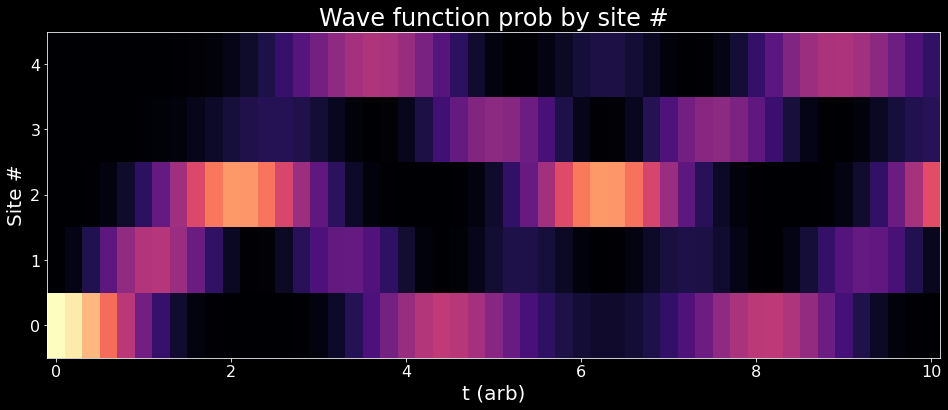

In [35]:
# lightness indicates probability
# excitation on site 0 is transmitted and reflected from the defect
# then mostly constructive interference around t=6

fig, ax = plt.subplots(1, 1, figsize=(16, 6))
plt.pcolormesh(time_range,
                    range(N_sites),
                    np.real(np.asarray(Nexps_values)),
                    shading='auto',
                    vmin = 0., vmax = 1.,
                    cmap = 'magma')
plt.title('Wave function prob by site #', fontsize = 24)
plt.xlabel('t (arb)', fontsize = 20)
plt.xticks(fontsize = 16)
plt.ylabel('Site #', fontsize = 20)
_ = plt.yticks(fontsize = 16)

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


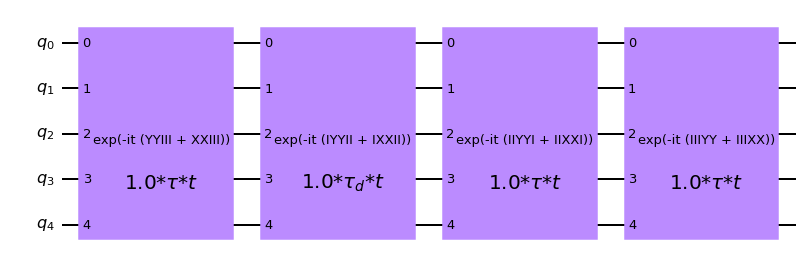

In [36]:
trot_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=1, reps=1)).convert(U_ham)
trot_op.to_circuit().draw(output='mpl', style={'subfontsize': 20})

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


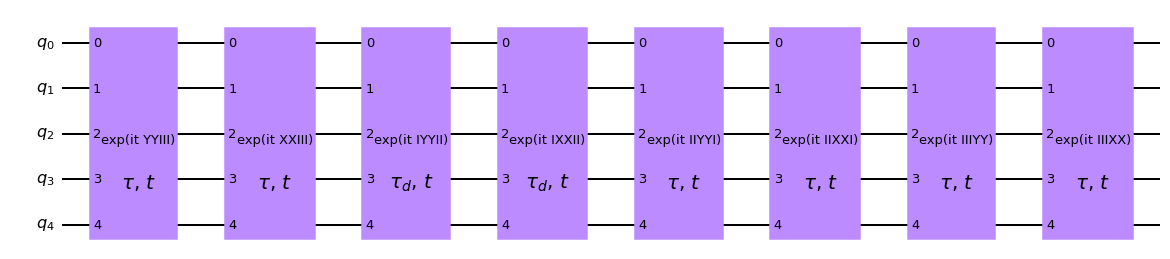

In [37]:
trot_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=1, reps=1)).convert(U_ham)
trot_op.to_circuit().decompose().draw(output='mpl', style={'subfontsize': 20})

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


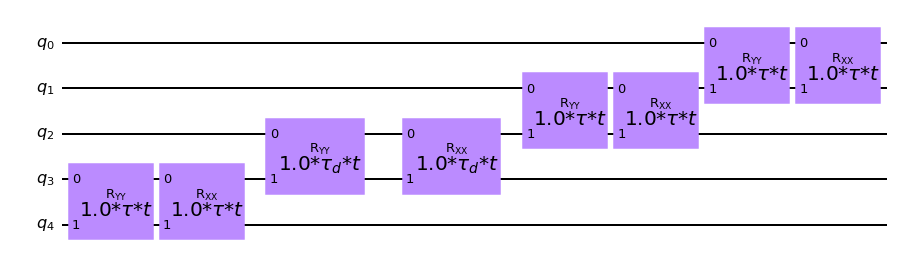

In [38]:
trot_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=1, reps=1)).convert(U_ham)
trot_op.to_circuit().decompose().decompose().draw(output='mpl', style={'subfontsize': 20})

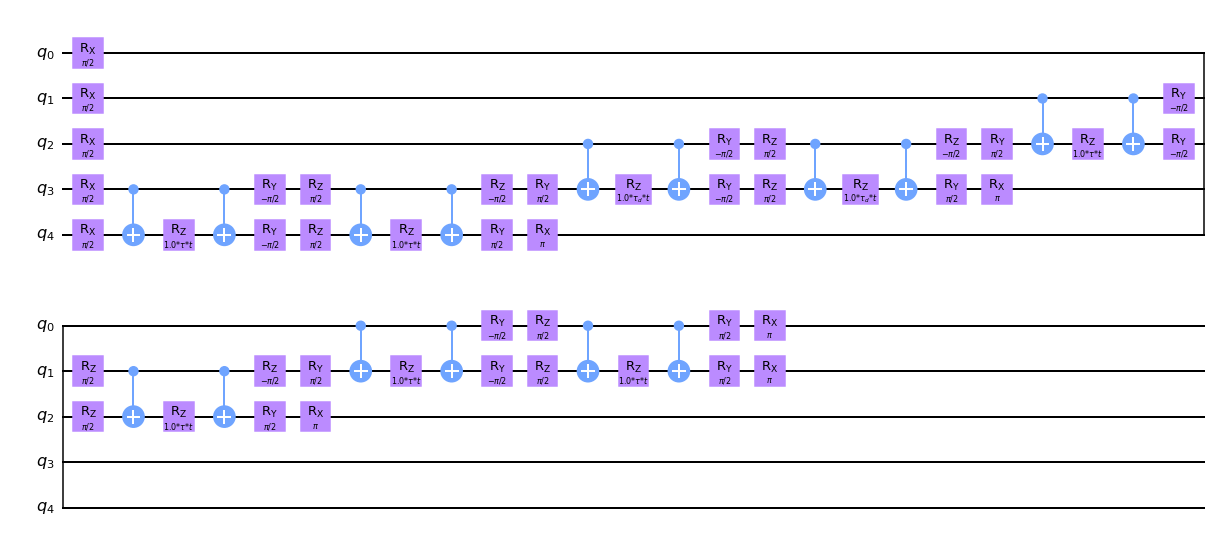

In [39]:
transpile(trot_op.to_circuit(), basis_gates=['rx', 'ry', 'rz', 'cx']).draw(output='mpl')

In [40]:
#IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend_sim = provider.get_backend('ibmq_qasm_simulator')

In [41]:
# trotterisation a way to approximate
num_trot_steps = 5
trot_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=2,
                                                    reps=num_trot_steps)).convert(U_ham)

trot_circ = QuantumCircuit(N_sites)
trot_circ.x(0)
trot_circ.compose(trot_op.to_circuit(), range(N_sites), inplace=True)
trot_circ.measure_all()

Nexp_circs = []
for t_set in time_range:
    param_bind[tt] = t_set
    trot_circ_t = transpile(trot_circ.bind_parameters(param_bind),
                            basis_gates=['rx', 'ry', 'rz', 'cx'])
    
    Nexp_circs.append(trot_circ_t)

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


In [ ]:
Nexp_circs[-1].draw('mpl')
# v. long circuit

In [42]:
job = backend_sim.run(Nexp_circs)
print(job.job_id())
job_monitor(job)

62f547e3c8061e8f5832cb82
Job Status: job has successfully run


In [43]:
total_counts = []

for result in job.result().results:
    counts = np.zeros((N_sites))
    for key in result.data.counts:
        key_bin = format(int(key.split('x')[1], 16), '0%ib' % N_sites)
        count = result.data.counts[key]
        for idx in range(N_sites):
            if key_bin[N_sites - idx - 1] == '1':
                counts[idx] += count
    total_counts.append(list(counts/sum(counts))) # normalise

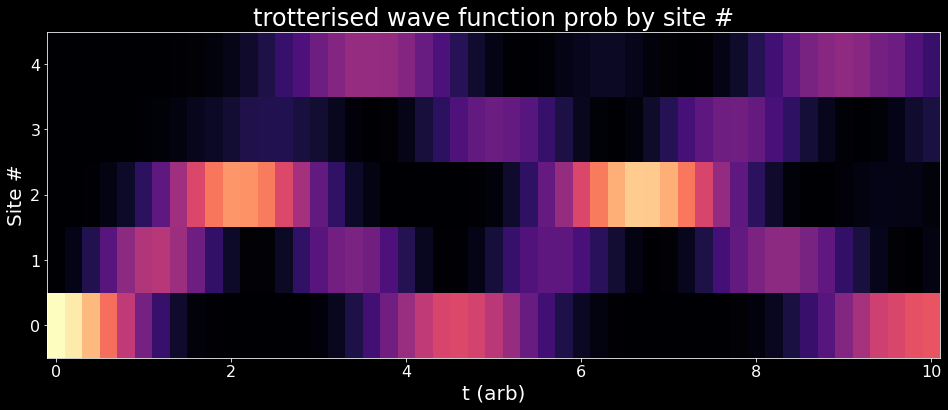

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
pcm = ax.pcolormesh(time_range,
                    range(N_sites),
                    np.transpose(np.asarray(total_counts)),
                    shading='auto',
                    vmin = 0., vmax = 1.,
                    cmap = 'magma')
plt.title('trotterised wave function prob by site #', fontsize = 24)
plt.xlabel('t (arb)', fontsize = 20)
plt.xticks(fontsize = 16)
plt.ylabel('Site #', fontsize = 20)
_ = plt.yticks(fontsize = 16)

In [45]:
from qiskit.tools.jupyter import *
%qiskit_version_table